# Loads Processing

## Load distribution pattern

In [1]:
import openseespy.opensees as ops

import opstool as opst


In [2]:
def model():
    ops.wipe()
    ops.model("basic", "-ndm", 3, "-ndf", 3)
    nodeTags = []
    for i in range(1, 11):
        ops.node(i, 0, 0, i)
        nodeTags.append(i)
    # Define your nodes and elements here
    # Define a load pattern
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    return nodeTags

### Triangle

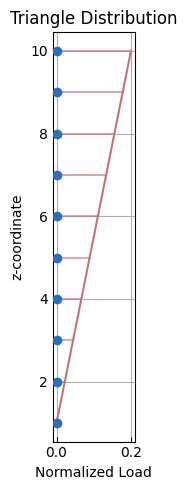

In [3]:
nodeTags = model()
node_loads = opst.pre.apply_load_distribution(
    node_tags=nodeTags, coord_axis="z", load_axis="x", dist_type="triangle", plot=True
)

### Parabola

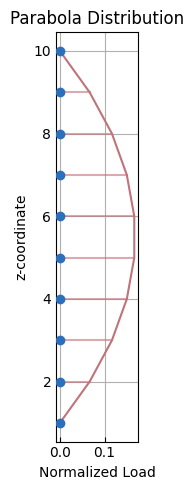

In [4]:
nodeTags = model()
node_loads = opst.pre.apply_load_distribution(
    node_tags=nodeTags, coord_axis="z", load_axis="x", dist_type="parabola", plot=True
)

### Semi-concave parabola

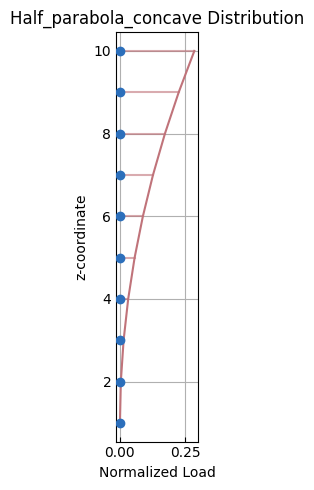

In [5]:
nodeTags = model()
node_loads = opst.pre.apply_load_distribution(
    node_tags=nodeTags,
    coord_axis="z",
    load_axis="x",
    dist_type="half_parabola_concave",
    plot=True,
)

### Semi-convex parabola

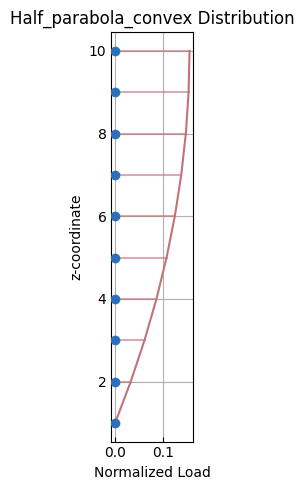

In [6]:
nodeTags = model()
node_loads = opst.pre.apply_load_distribution(
    node_tags=nodeTags,
    coord_axis="z",
    load_axis="x",
    dist_type="half_parabola_convex",
    plot=True,
)

### Uniform

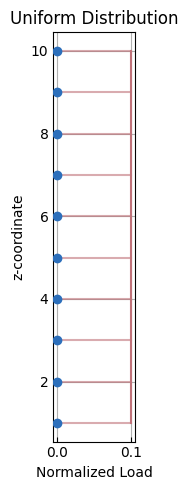

In [7]:
nodeTags = model()
node_loads = opst.pre.apply_load_distribution(
    node_tags=nodeTags, coord_axis="z", load_axis="x", dist_type="uniform", plot=True
)

## Element Load Transformation

### Beam load

This document describes the process of transforming element loads, such as **uniformly distributed loads (UDL)** and **point loads**, from the **global coordinate system** to the **local coordinate system**.

In [ ]:
import openseespy.opensees as ops

import opstool as opst


#### 2D Case

First we create three 2D beam elements:

In [9]:
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)
ops.node(1, 0, 0)
ops.node(2, 0, 2)
ops.node(3, 2, 2)

ops.geomTransf("Linear", 1)
ops.element("elasticBeamColumn", 1, 1, 2, 1000, 10000, 10000, 1)
ops.element("elasticBeamColumn", 2, 2, 3, 1000, 10000, 10000, 1)
ops.element("elasticBeamColumn", 3, 1, 3, 1000, 10000, 10000, 1)

Then, the time series and load pattern are created, followed by the generation of beam element loads using two functions that can easily transform the loads in the global coordinate system to the local coordinate system of each beam element and generate the loads using the [EleLoad Command](https://opensees.berkeley.edu/wiki/index.php/EleLoad_Command) in OpenSees.

In [10]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

opst.pre.transform_beam_uniform_load([1, 2, 3], wy=-2)

ops.pattern("Plain", 2, 1)
opst.pre.transform_beam_point_load([1, 2, 3], py=-3, xl=0.5)

We can check this visually. We can see that our loads are along the global Y axis and they are correctly transformed to each beam element according to their local axes.

In [ ]:
fig = opst.vis.plotly.plot_model(show_ele_loads=True, show_nodal_loads=True, load_scale=2)
# fig.show()
fig

In [12]:
fig.write_html("images/beamLoad2D_plotly.html", full_html=False, include_plotlyjs="cdn")

#### 3D Case

In [13]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
ops.node(1, 0, 0, 0)
ops.node(2, 0, 2, 0)
ops.node(3, 2, 2, 0)
ops.node(4, 2, 0, 0)

ops.geomTransf("Linear", 1, 0, 0, 1)
ops.element("elasticBeamColumn", 1, 1, 2, 1000, 1000, 1000, 1000, 1000, 1000, 1)
ops.element("elasticBeamColumn", 2, 2, 3, 1000, 1000, 1000, 1000, 1000, 1000, 1)
ops.element("elasticBeamColumn", 3, 3, 4, 1000, 1000, 1000, 1000, 1000, 1000, 1)
ops.element("elasticBeamColumn", 4, 4, 1, 1000, 1000, 1000, 1000, 1000, 1000, 1)
ops.element("elasticBeamColumn", 5, 1, 3, 1000, 1000, 1000, 1000, 1000, 1000, 1)

In [14]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

opst.pre.transform_beam_uniform_load([1, 2, 3, 4, 5], wy=2, wz=-2)

ops.pattern("Plain", 2, 1)
opst.pre.transform_beam_point_load([1, 2, 3, 4, 5], py=2, pz=-3, xl=0.5)

We can check this visually and see that our loads are correctly transformed into the local axes of each beam element.

In [15]:
fig = opst.vis.plotly.plot_model(show_ele_loads=True, show_nodal_loads=True, load_scale=2, show_local_axes=True)
# fig.show()

In [16]:
fig.write_html("images/beamLoad3D_plotly.html", full_html=False, include_plotlyjs="cdn")

### Surface Load

According to the static equivalence principle, the surface distributed load is equivalent to the node load.

In [17]:
import opstool as opst
import openseespy.opensees as ops

In [18]:
ops.wipe()
# set up a 3D-6DOFs model
ops.model("Basic", "-ndm", 3, "-ndf", 6)
ops.node(1, 0.0, 0.0, 0.0)
ops.node(2, 1.0, 0.0, 0.0)
ops.node(3, 1.0, 1.0, 0.0)
ops.node(4, 0.0, 1.0, 0.0)

ops.node(5, 2.0, 0.0, 0.0)
ops.node(6, 2.0, 1.0, 0.0)

ops.fix(1, *([1] * 6))
ops.fix(4, *([1] * 6))

# create a fiber shell section with 4 layers of material 1
# each layer has a thickness = 0.025
ops.nDMaterial("ElasticIsotropic", 1, 1000.0, 0.2)
ops.section("LayeredShell", 11, 4, 1, 0.025, 1, 0.025, 1, 0.025, 1, 0.025)
# create the shell element using the small displacements/rotations assumption
ops.element("ASDShellQ4", 1, 1, 2, 3, 4, 11)
ops.element("ASDShellT3", 2, 2, 5, 6, 11)
ops.element("ASDShellT3", 3, 6, 3, 2, 11)

Using ASDShellQ4 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology
Using ASDShellT3 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


In [19]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

opst.pre.transform_surface_uniform_load(ele_tags=[1, 2, 3], p=-1)

Since the surface load intensity is 1 and the total area is 2, the total load on the three elements is 2.0. The sum of the nodal loads assigned to all nodes should equal 2.0.

In [20]:
fig = opst.vis.plotly.plot_model(show_nodal_loads=True, load_scale=2)
fig.show()

In [21]:
fig.write_html("images/surfaceLoad3D_plotly.html", full_html=False, include_plotlyjs="cdn")

#### Analysis and Results

In [22]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [23]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

In [24]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
node_resp

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-1.nc ...

<xarray.Dataset> Size: 10kB
Dimensions:             (time: 11, nodeTags: 6, DOFs: 6)
Coordinates:
  * time                (time) float64 88B 0.0 0.1 0.2 0.3 ... 0.7 0.8 0.9 1.0
  * nodeTags            (nodeTags) int32 24B 1 2 3 4 5 6
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
Data variables:
    disp                (time, nodeTags, DOFs) float32 2kB 0.0 ... -3.169e-17
    vel                 (time, nodeTags, DOFs) float32 2kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float32 2kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float32 2kB 0.0 0.0 ... 5.236e-17
    reactionIncInertia  (time, nodeTags, DOFs) float32 2kB 0.0 0.0 ... 5.236e-17
    rayleighForces      (time, nodeTags, DOFs) float32 2kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float32 264B 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displacement in Z direction
    RX:       Rotation about X axis
    RY:       Rotation about Y axis
    RZ:       Rotation about Z axis

Retrieve displacement:

In [25]:
node_disp = node_resp["disp"].sel(nodeTags=[5, 6], DOFs="UZ")
node_disp.data

array([[  0.       ,   0.       ],
       [ -2.5138178,  -2.5966835],
       [ -5.0276356,  -5.193367 ],
       [ -7.5414534,  -7.79005  ],
       [-10.055271 , -10.386734 ],
       [-12.569089 , -12.9834175],
       [-15.082907 , -15.5801   ],
       [-17.596725 , -18.176785 ],
       [-20.110542 , -20.773468 ],
       [-22.624361 , -23.370152 ],
       [-25.138178 , -25.966835 ]], dtype=float32)

Retrieve node reactions:

In [26]:
node_react = node_resp["reaction"].sel(nodeTags=[1, 4], DOFs="UZ")
node_react.data

array([[0.        , 0.        ],
       [0.10629704, 0.09370296],
       [0.21259408, 0.18740591],
       [0.3188911 , 0.2811089 ],
       [0.42518815, 0.37481183],
       [0.5314852 , 0.4685148 ],
       [0.6377822 , 0.5622178 ],
       [0.7440793 , 0.65592074],
       [0.8503763 , 0.74962366],
       [0.9566734 , 0.8433266 ],
       [1.0629704 , 0.9370296 ]], dtype=float32)